<div style="border:solid purple 2px; padding: 20px">
    
Марина привет! 👋 Меня зовут Рустам и мы уже знакомы, я проверял твою первую работу) Коротко обозначу вступление, я оставил комментарии, разных цветов, обрати в первую очередь на красные (если они будут 😊). Свои изменения прошу как-то выделять и также прошу не перемещать и не удалять мои комментарии
    
Мне понравился твой проект, как и прошлый)))) После того, как ты все доработаешь, я смогу его принять!) В конце есть чек-лист😉

</div>

# **Определение перспективного тарифа для телеком-компании** 

# Оглавление
1. [Цель проекта](#purpose)
2. [Исходные данные](#data)
3. [Предобработка данных](#preprocessing)
    * [Объединение таблиц users и tariffs](#merging)
    * [Округление длительности звонков и интернет-трафика по условиям тарифа, группировка данных по месяцам](#round)
    * [Сведение всех данных в единый датасет](#merging_2)
    * [Удаление пустых значений и изменение типа данных столбцов](#dropna)
4. [Подготовка расчётных данных](#counting)
    * [Расчёт ежемесячной выручки по пользователям](#month_revenue)
    * [Промежуточные выводы](#concl)
5. [Анализ данных](#analysis)
    * [Доли тарифов в выборке](#pie)
    * [Динамика соотношения тарифов по месяцам](#part_month)
    * [Анализ характеристик распределения данных](#describe)
    * [Гистограммы распределений](#hist)
6. [Проверка гипотез (анализ выручки)](#revenue)
    * [Анализ характеристик распределения выручки](#revenue_describe)
    * [Проверка гипотезы о равенстве выручки по тарифам](#hyp1)
    * [Проверка гипотезы равенства выручки в Москве и регионах](#hyp2)
7. [Выводы](#end)

# 1. Цель проекта <a id="purpose"></a>




По относительно небольшой выборке пользоваталей сотовой сети нужно определить более финансово интересный для компании тариф.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Отличное начало, все есть, чтобы погрузиться в задачу

# 2. Исходные данные <a id="data"></a>

Имеем массив данных с информацией о 500 пользователей телеком-компании и о том, какие тарифы сотовой связи они используют. В наличии несколько файлов:

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 16, 5
from scipy.stats import levene
from scipy.stats import bartlett

In [2]:
#Просмотрим информацию о каждом файле:
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tables = (tariffs, users, calls, internet, messages)
for table in tables:
    display(table.info())
    display(table.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Применять циклы для повторяющихся действий - очень правльное решение

<div class="alert alert-success">
Привет, Рустам! В колабе у меня было еще круче:
    
    for filename in glob('/content/*'):
  if filename.endswith('csv'):
    filename = pd.read_csv(filename, engine = 'python')
    display(filename.info())
    display(filename.head())
    
    Но здесь я не смогла так сделать - слишком много файлов лежит в папке datasets. 
    Может, внести предложение для каждого проекта свою папочку с исходниками делать?


<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

Да, можно, предложу своим, думаю это было бы удобно

Итак, у нас есть следующие файлы: 


1.   Файл `users` со списком пользователей, где содержится их ФИО и город проживания, а также название тарифа сотовой связи, которым они пользуются.
2.   Файл-справочник `tariffs` с описанием тарифов **smart** и **ultra**.
3.   Файл `calls` со сведениями по количеству и продолжительности звонков.
4.   Файл `internet` с информацией о потраченном интернет-трафике.
5.   Файл `messages` с указанием количества отправленных пользователями sms-сообщений.



# 3. Предобработка данных <a id="preprocessing"></a>

Сведём файлы в единую базу для удобства проведения анализа. В первую очередь соединим данные из таблиц `users` и `tariffs`. <a id="merging"></a>

In [3]:
#Корректируем названием столбца с тарифом для корректного слияния:
tariffs.rename(columns=lambda x: x.replace('tariff_name', 'tariff'), inplace=True)
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
#Объединяем таблицы по данным столбца с тарифом:
users = users.merge(tariffs, on = 'tariff', how = 'left')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1


В таблице звонков есть строки с нулевой длительностью разговора. Вероятно, это сброшенные/ошибочные звонки. Посчитаем, сколько таких строк.     <a id="round"></a>

In [5]:
#Фильтруем звонки с нулевой длительностью:
calls_0 = calls[calls['duration'] == 0]
calls_part = len(calls_0)/len(calls)
print('В таблице {} строк с пропущенными звонками, то есть {:.2%} всей выборки.'.format(len(calls_0), calls_part))

В таблице 39613 строк с пропущенными звонками, то есть 19.55% всей выборки.


Таких значений оказалось слишком много, чтобы просто избавиться от них. Так как звонок зафиксирован сетью, мобильный оператор снял за него деньги за 1 минуту разговора. Заменим все нулевые значения длительности единицами, а все минуты разговора округлим в большую сторону.


---


Поскольку тарифный план предусматривает ежемесячную оплату, сразу сгруппируем помесячно все данные по звонкам, интернет-трафику и сообщениям.

<div class = "alert alert-success">
<h2> Комментарии ревьюера <a class="tocSkip"> </h2>

Логичная аргументация 👍 В реальном бизнесе, я думаю ты согласишься, что нужно задать вопрос разработчикам про данные с нулевой длительностью

</div>

In [6]:
calls.loc[calls['duration'] == 0, 'duration'] = 1
calls['duration_rounded'] = np.ceil(calls.duration).astype(int)
calls['call_date'] = calls['call_date'].astype('datetime64[ns]')
calls['month'] = pd.to_datetime(calls['call_date']).dt.strftime('%m %B')
calls_grouped = calls.pivot_table(index = ['user_id','month'], values = 'duration_rounded', aggfunc = 'sum').reset_index()
calls_grouped.columns = ['user_id', 'month', 'duration_rounded']
display(calls_grouped.sample(5))

,user_id,month,duration_rounded
550,1088,07 July,334
2954,1465,07 July,681
27,1004,10 October,153
419,1065,11 November,547
2195,1352,12 December,726


<div class = "alert alert-success">
<h2> Комментарии ревьюера <a class="tocSkip"> </h2>

Супер! Молодец, что не забыла округлить данные

</div>

Таким же образом округлим до целых мегабайт показатели интернет-трафика и сгруппируем данные по месяцам.

In [7]:
internet['mb_used_rounded'] = np.ceil(internet.mb_used).astype(int)
#Удалим столбец, дублирующий индексы таблицы:
internet = internet.drop(['Unnamed: 0'], axis = 1)
#Добавим месяц использования трафика:
internet['session_date'] = internet['session_date'].astype('datetime64[ns]')
internet['month'] = pd.to_datetime(internet['session_date']).dt.strftime('%m %B')
#Сгруппируем данные помесячно:
internet_grouped = internet.pivot_table(index = ['user_id','month'], values = 'mb_used_rounded', aggfunc = 'sum').reset_index()
internet_grouped.columns = ['user_id', 'month', 'mb_used_rounded']
display(internet_grouped.sample(5))

,user_id,month,mb_used_rounded
1396,1219,03 March,22040
617,1098,06 June,8261
1675,1264,12 December,16723
2870,1451,09 September,9816
1606,1253,10 October,26044


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Кстати, этот столбец можно было указать в качестве индексов, во время загрузки датафрейма. Для этого тебе нужно задать параметр [index_col](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html). И мне очень нравится решение с `dt.strftime`

Аналогично сгруппируем данные по сообщениям.

In [8]:
messages['session_date'] = messages['message_date'].astype('datetime64[ns]')
messages['month'] = pd.to_datetime(messages['message_date']).dt.strftime('%m %B')
#Сгруппируем данные помесячно:
messages_grouped = messages.pivot_table(index = ['user_id','month'], values = 'message_date', aggfunc = 'count').reset_index()
messages_grouped.columns = ['user_id', 'month', 'messages_number']
display(messages_grouped.sample(5))

,user_id,month,messages_number
195,1035,06 June,51
2310,1426,09 September,71
1190,1229,12 December,6
1410,1274,08 August,75
2681,1492,07 July,19


<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Обрати, пожалуйста, внимание на использование `head`, `tail` или `sample` при форматировании датафреймов. Не забывай про них. Если оставить эту таблицу "как есть", то при сохранении ноутбука, например, на github, таблица развернется во всю длину и займет значительную часть отчета.

<div class="alert alert-success">
СДЕЛАНО!

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

👍👍👍

Таблицы готовы к объединению. Сформируем датасет из всех необходимых для анализа данных.     <a id="merging_2"></a>

In [9]:
#Сначала сливаем данные по месяцам и id пользователей, потом привязываем их к ФИО и личным данным клиентов:
data = internet_grouped.merge(messages_grouped, on = ['user_id', 'month'], how = 'outer')
data = data.merge(calls_grouped, on = ['user_id', 'month'], how = 'outer')
data = data.merge(users, on = 'user_id', how = 'outer')
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
user_id                  3216 non-null int64
month                    3214 non-null object
mb_used_rounded          3203 non-null float64
messages_number          2717 non-null float64
duration_rounded         3174 non-null float64
age                      3216 non-null int64
churn_date               189 non-null object
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null object
tariff                   3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: float64(3), int64(

,user_id,month,mb_used_rounded,messages_number,duration_rounded,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3211,1273,10 October,NaN,35.0,320.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3212,1273,11 November,NaN,29.0,286.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3213,1273,12 December,NaN,39.0,263.0,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1
3214,1128,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1
3215,1371,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Молодец, что проводишь объединение задавая параметр `how='outer'`. Так мы не потеряем данные

Для удобства использования датасета изменим порядок отображения столбцов.

In [10]:
cols = list(data.columns.values)
data = (data
    [['user_id', 'age', 'first_name', 'last_name', 'city', 
 'tariff', 'reg_date', 'churn_date',
 'month',
 'mb_used_rounded',
 'messages_number',
 'duration_rounded',
 'messages_included',
 'mb_per_month_included',
 'minutes_included',
 'rub_monthly_fee',
 'rub_per_gb',
 'rub_per_message',
 'rub_per_minute']]
)
data.head(3)

,user_id,age,first_name,last_name,city,tariff,reg_date,churn_date,month,mb_used_rounded,messages_number,duration_rounded,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Рафаил,Верещагин,Краснодар,ultra,2018-05-25,NaN,05 May,2256.0,22.0,164.0,1000,30720,3000,1950,150,1,1
1,1000,52,Рафаил,Верещагин,Краснодар,ultra,2018-05-25,NaN,06 June,23257.0,60.0,187.0,1000,30720,3000,1950,150,1,1
2,1000,52,Рафаил,Верещагин,Краснодар,ultra,2018-05-25,NaN,07 July,14016.0,75.0,346.0,1000,30720,3000,1950,150,1,1


В столбцах `mb_used_rounded`, `messages_number`, `duration_rounded` после объединения появились пустые значения. Кто-то из клиентов сети использует интернет, но не звонит, или общается только с помощью сообщений. Заменяем в этих столбцах пустые ячейки на нулевые, а вещественный тип данных на целочисленный.    <a id="dropna"></a>

In [11]:
columns_na = ['mb_used_rounded', 'messages_number', 'duration_rounded']
data[columns_na] = data[columns_na].fillna(0).astype(int)
display(data[data['month'].isna()])

,user_id,age,first_name,last_name,city,tariff,reg_date,churn_date,month,mb_used_rounded,messages_number,duration_rounded,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3214,1128,51,Ксения,Агаева,Волжский,ultra,2018-12-15,2018-12-23,NaN,0,0,0,1000,30720,3000,1950,150,1,1
3215,1371,50,Ириней,Трофимов,Омск,smart,2018-12-25,2018-12-30,NaN,0,0,0,50,15360,500,550,200,3,3


В колонке "месяц" две пустые строки - два клиента не использовали купленный тариф. Это подтверждает и разница в несколько дней между датой регистрации и датой закрытия тарифа. Для подсчета выручки компании эти строки неинформативны, их можно удалить из датасета.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Согласен

In [12]:
data = data.dropna(subset = ['month']).reset_index()
#Проверка, закомментирована для компактности
#data.info() 

# 4. Подготовка расчётных данных <a id="counting"></a>

Рассчитаем ежемесячную выручку по каждому пользователю.  <a id="month_revenue"></a>

In [13]:
#Создаем столбцы, в которые попадёт сумма выручки компании при превышении клиентом лимита по тарифам:
data['revenue_calls'] = (data['duration_rounded'] - data['minutes_included']) * data['rub_per_minute']
data['revenue_internet'] = (data['mb_used_rounded'] - data['mb_per_month_included']) * data['rub_per_gb'] / 1024
data['revenue_messages'] = (data['messages_number'] - data['messages_included']) * data['rub_per_message']
#В случае, если превышения нет, оставим в этих столбцах нули:
data.loc[data['revenue_calls'] < 0, 'revenue_calls'] = 0
data.loc[data['revenue_internet'] < 0, 'revenue_internet'] = 0
data.loc[data['revenue_messages'] < 0, 'revenue_messages'] = 0
#Итоговая выручка складывается из тарифа и оплаты за превышение трафика, лимита минут и сообщений:
data['revenue_month'] = data['rub_monthly_fee'] + data['revenue_calls'] + data['revenue_internet'] + data['revenue_messages']
#Проверка:
data[['rub_monthly_fee', 'duration_rounded', 'minutes_included', 'rub_per_minute', 'mb_used_rounded','mb_per_month_included','rub_per_gb', 'messages_number', 'messages_included', 'rub_per_message', 'revenue_calls', 'revenue_internet', 'revenue_messages', 'revenue_month']].tail(20)

,rub_monthly_fee,duration_rounded,minutes_included,rub_per_minute,mb_used_rounded,mb_per_month_included,rub_per_gb,messages_number,messages_included,rub_per_message,revenue_calls,revenue_internet,revenue_messages,revenue_month
3194,550,533,500,3,20757,15360,200,51,50,3,99,1054.101562,3,1706.101562
3195,550,506,500,3,11512,15360,200,20,50,3,18,0.000000,0,568.000000
3196,550,387,500,3,14174,15360,200,14,50,3,0,0.000000,0,550.000000
3197,550,558,500,3,19940,15360,200,17,50,3,174,894.531250,0,1618.531250
3198,550,178,500,3,7486,15360,200,20,50,3,0,0.000000,0,550.000000
3199,550,414,500,3,24270,15360,200,62,50,3,0,1740.234375,36,2326.234375
3200,550,477,500,3,22166,15360,200,44,50,3,0,1329.296875,0,1879.296875
3201,550,258,500,3,20604,15360,200,42,50,3,0,1024.218750,0,1574.218750
3202,550,71,500,3,1848,15360,200,11,50,3,0,0.000000,0,550.000000
3203,550,473,500,3,17809,15360,200,48,50,3,0,478.320312,0,1028.320312


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Все правильно, я бы решение обернул в функции для более элегантного вида

<div class="alert alert-success">
Рустам, можешь дать небольшую подсказку, как начать функцию? Сама хочу, но, видимо, опыта не хватает. Не знаю, как подступиться.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Я в свое время когда работу выполнял, что-то похожее на такую функцию писал. Там возможно решение немного будет отличаться от твоего, но сама мысль думаю понятна)

In [39]:
df_tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv', index_col = 'tariff_name')

def month_revenue(row):

    minutes = row['duration_rounded']
    messages = row['messages_number']
    internet = row['mb_used_rounded'] 
    tariff = row['tariff']

    minutes_lim = df_tariffs.loc[tariff, 'minutes_included']
    message_lim = df_tariffs.loc[tariff, 'messages_included']
    internet_lim = df_tariffs.loc[tariff, 'mb_per_month_included']
    monthly_fee = df_tariffs.loc[tariff, 'rub_monthly_fee']

    call_overlimit = max(minutes - minutes_lim, 0)
    call_overpay = call_overlimit * df_tariffs.loc[tariff, 'rub_per_minute']
    
    message_overlimit = max(messages - message_lim, 0)
    message_overpay = message_overlimit * df_tariffs.loc[tariff, 'rub_per_message']
    
    internet_overlimit = max(np.ceil((internet - internet_lim)/1024), 0)
    internet_overpay = internet_overlimit * df_tariffs.loc[tariff, 'rub_per_gb']
    
    return monthly_fee + call_overpay + message_overpay + internet_overpay

data.apply(month_revenue, axis = 1).head(20)

0     1950.0
1     1950.0
2     1950.0
3     1950.0
4     1950.0
5     1950.0
6     1950.0
7     1950.0
8     1350.0
9      550.0
10     550.0
11    1150.0
12    1550.0
13     950.0
14     550.0
15    1350.0
16    1150.0
17    1950.0
18    1950.0
19    1950.0
dtype: float64

Итак:
 

*   Информация об использовании тарифов сгруппирована по месяцам;
*   Собрана из разрозненных файлов в единый датафрейм;
*   Данные проверены на ошибки;
*   Убраны пустые значения;
*   В таблицу добавлен расчётный столбец ежемесячной выручки по каждому пользователю.

Приступаем к анализу полученных данных.

<a id="concl"></a>   

# 5. Анализ данных <a id="analysis"></a>

В первую очередь, посмотрим, каким тарифом предпочитают пользоваться клиенты "Мегалайна". Построим круговую диаграмму: <a id="pie"></a>

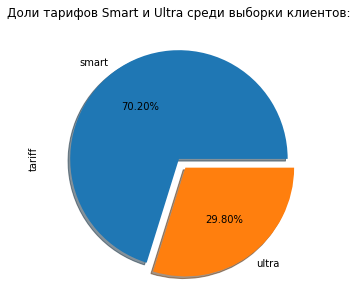

In [15]:
#Диаграмма на основе данных списка клиентов:
users['tariff'].value_counts().plot(kind = 'pie', autopct='%1.2f%%', explode = (0, 0.1), shadow = True)
plt.title('Доли тарифов Smart и Ultra среди выборки клиентов:')
plt.show()

70% клиентов "Мегалайна" предпочитают универсальный и недорогой тариф Smart. 

Проверим, как меняются доли тарифов в выборке по месяцам. Возможно, не всегда соотношение было таким. <a id="part_month"></a>

In [16]:
#Группируем таблицу по месяцу и тарифу. Данные - количество пользователей.
grouped_data = data.groupby(['month', 'tariff'])['user_id'].count().reset_index().sort_values(by = ['month','user_id'])
grouped_data.columns = ['month', 'tariff', 'count_users_part']
#Групппируем таблицу только по месяцу без разбивки по тарифам.
grouped_data_2 = data.groupby('month')['user_id'].count().reset_index()
grouped_data_2.columns = ['month', 'count_users_total']
#Объединяем обе таблицы по месяцу:
grouped_data = grouped_data.merge(grouped_data_2, on = 'month', how = 'left').sort_values(by = ['month','tariff'])
#Добавляем столбец с долей пользователя конкретного тарифа от общего количества пользователей:
grouped_data['%'] = grouped_data['count_users_part'] * 100/ grouped_data['count_users_total']
grouped_data.head(4)



,month,tariff,count_users_part,count_users_total,%
1,01 January,smart,34,43,79.069767
0,01 January,ultra,9,43,20.930233
3,02 February,smart,58,82,70.731707
2,02 February,ultra,24,82,29.268293


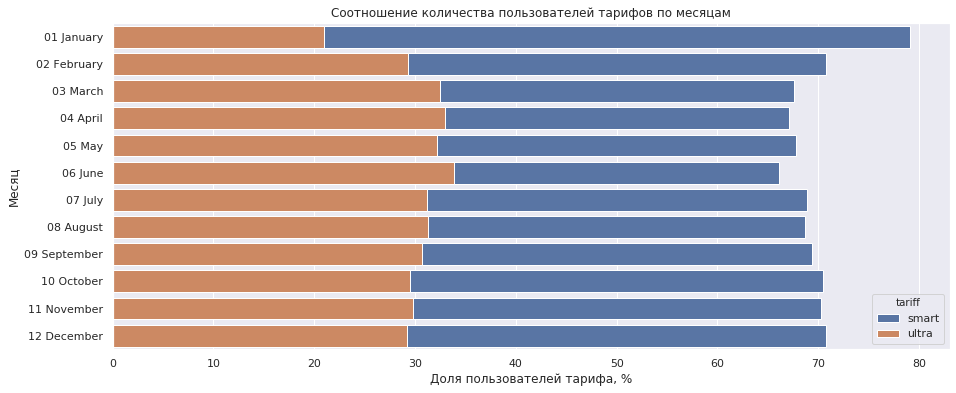

In [17]:
#Строим столбчатую диаграмму, показывающую доли пользователей в разрезе месяца:
month = grouped_data['month']
tariff = grouped_data['tariff']
part = grouped_data['%']
sns.set()
plt.figure(figsize = (15,6))
ax = sns.barplot(y= month, x = part, hue = tariff, dodge = False)
ax.set(title = "Соотношение количества пользователей тарифов по месяцам",
      ylabel = "Месяц",
      xlabel = "Доля пользователей тарифа, %")
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👏 Отличный график, разверни ось икс на 90 градусов, декабрь с ноябрем залезли друг на друга

![](https://i.gifer.com/R0YH.gif)

<div class="alert alert-success">
    СДЕЛАНО!

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Лучше и не придумаешь

В январе доля пользователей тарифа Smart была 80%, затем в течение полугода начала снижаться примерно до 65%, затем опять приблизилась к средним 70%.

В первую очередь посмотрим на характеристики распределения данных. <a id="describe"></a>

In [18]:
data_ultra = data.query('tariff == "ultra"')
data_smart = data.query('tariff == "smart"')
print('Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Smart":')
display(data_smart[['duration_rounded', 'mb_used_rounded', 'messages_number']].describe().style.format('{:.2f}'))
var_smart = np.var(data_smart[['duration_rounded', 'mb_used_rounded', 'messages_number']], ddof = 1).astype(int)
print('Дисперсия распределения по показателям тарифа "Smart":')
display(var_smart)
print('Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Ultra":')
display(data_ultra[['duration_rounded', 'mb_used_rounded', 'messages_number']].describe().style.format('{:.2f}'))
print('Дисперсия распределения по показателям тарифа "Ultra":')
var_ultra = np.var(data_ultra[['duration_rounded', 'mb_used_rounded', 'messages_number']], ddof = 1).astype(int)
display(var_ultra)

Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Smart":


,duration_rounded,mb_used_rounded,messages_number
count,2229.00,2229.00,2229.00
mean,429.45,16229.19,33.38
std,194.87,5877.58,28.23
min,0.00,0.00,0.00
25%,291.00,12658.00,10.00
50%,435.00,16531.00,28.00
75%,560.00,20068.00,51.00
max,1471.00,38610.00,143.00


Дисперсия распределения по показателям тарифа "Smart":


duration_rounded       37974
mb_used_rounded     34545911
messages_number          796
dtype: int64

Характеристики распределения длительности разговора, интернет-трафика и количества сообщений для тарифа "Ultra":


,duration_rounded,mb_used_rounded,messages_number
count,985.00,985.00,985.00
mean,540.78,19486.90,49.36
std,325.74,10096.32,47.80
min,0.00,0.00,0.00
25%,292.00,11785.00,6.00
50%,532.00,19324.00,38.00
75%,773.00,26863.00,79.00
max,1727.00,49789.00,224.00


Дисперсия распределения по показателям тарифа "Ultra":


duration_rounded       106105
mb_used_rounded     101935621
messages_number          2285
dtype: int64

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Я бы дисперсию оставил в решении, в задании просят же найти их. Также обрати внимание на параметр `ddof` при подсчете [дисперсии](https://numpy.org/doc/stable/reference/generated/numpy.var.html)

</div>

<div class="alert alert-success">
    СДЕЛАНО!

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

А вот пример, как можно было дисперсию включить в таблицу и оставить только нужное. Да, решение длинное, но вдруг будет полезным)

In [49]:
data_ultra[['duration_rounded', 'mb_used_rounded', 'messages_number']].describe().loc[['mean', \
'std']].append(pd.Series(np.var(data_ultra[['duration_rounded', 'mb_used_rounded', \
'messages_number']], ddof = 1), name = 'var')).style.format('{:.2f}')

,duration_rounded,mb_used_rounded,messages_number
mean,540.78,19486.90,49.36
std,325.74,10096.32,47.80
var,106105.73,101935621.05,2285.27


<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

Через сводные таблицы наверное короче будет

In [52]:
data.pivot_table(index='tariff',  
                 values=['duration_rounded', 'mb_used_rounded', 'messages_number'], 
                 aggfunc=['mean', 'std', 'var']).T.style.format('{:.2f}')

По характеристикам распределения можно сделать выводы:
*   **Средняя длительность разговора не сильно зависит от тарифа**. В среднем человеку нужно около 430 минут разговора на тарифе "Smart" и 540 - на тарифе "Ultra". Среднее и медиана у распределения близки, т.е. выбросов немного.
*   **Сообщения сейчас не в моде**. Пользователи обоих тарифов за редким исключением не превышают лимит.
*   **Основные различия касаются объема интернет-трафика**. Пользователи тарифа "Smart" превышают лимит 15Гб и платят за дополнительные мегабайты чаще, чем в половине случаев. Пользователи "Ultra" используют интернет активнее (в среднем на 3Гб), но больше чем в 75% случаев не выходят за увеличенный лимит в 30Гб.



Для наглядности построим сравнительные графики длительности разговора, отправки смс и активности пользователя в сети в зависимости от выбранного тарифа. <a id="hist"></a>

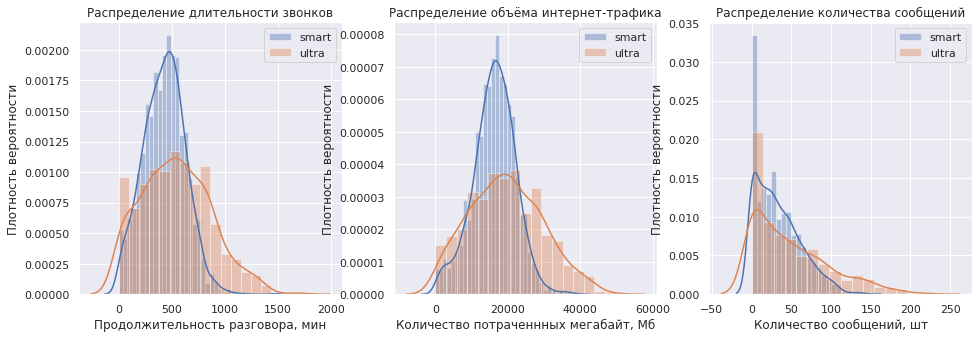

In [19]:
#Строим гистограммы распределений ежемесячной длительности разговора, количества сообщений и объема интернет-трафика:
#tariff = data['tariff']
sns.set()
fig,axes=plt.subplots(1,3)
for tariff in ['smart', 'ultra']:
  ax = sns.distplot(data.query('tariff == @tariff')['duration_rounded'], label = tariff, ax = axes[0])
  ax1 = sns.distplot(data.query('tariff == @tariff')['mb_used_rounded'], label = tariff, ax = axes[1])
  ax2 = sns.distplot(data.query('tariff == @tariff')['messages_number'], label = tariff, ax = axes[2])

ax.set(title = "Распределение длительности звонков",
      xlabel = "Продолжительность разговора, мин",
      ylabel = "Плотность вероятности")
ax1.set(title = "Распределение объёма интернет-трафика",
      xlabel = "Количество потраченнных мегабайт, Мб",
      ylabel = "Плотность вероятности")
ax2.set(title = "Распределение количества сообщений",
      xlabel = "Количество сообщений, шт",
      ylabel = "Плотность вероятности")
      
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Отличный график 👏
    
![](https://i.gifer.com/NdG.gif)

В целом поведение пользователя в обоих случаях похожее, но на графиках видно **смещение вправо** распределения длительности звонков и объёма интернет-трафика **по тарифу "Ultra"**. Лимиты больше - использование свободнее.

Эти распределения близки к нормальным. **Распределение количества сообщений стремится к экспоненциальному виду**. Максимум около нуля. Пользователей, отправляющих много sms, мало.

# 6. Проверка гипотез (анализ выручки) <a id="revenue"></a>

В первую очередь посчитаем характеристики распределения выручки по тарифам. <a id="revenue_describe"></a>

In [20]:
print('Характеристики распределения ежемесячной выручки по тарифу "Smart":')
display(data_smart[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки по тарифу "Ultra":')
display(data_ultra[['revenue_month']].describe().style.format('{:.2f}'))

Характеристики распределения ежемесячной выручки по тарифу "Smart":


,revenue_month
count,2229.00
mean,1250.33
std,797.03
min,550.00
25%,553.00
50%,986.49
75%,1701.56
max,6765.02


Характеристики распределения ежемесячной выручки по тарифу "Ultra":


,revenue_month
count,985.00
mean,2060.53
std,356.31
min,1950.00
25%,1950.00
50%,1950.00
75%,1950.00
max,4743.31


Построим гистограммы распределения выручки по тарифам.

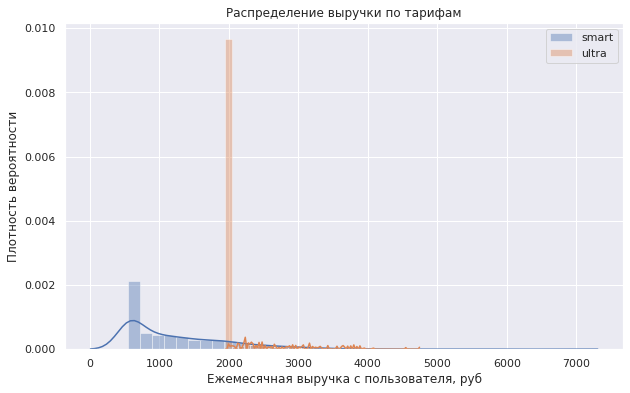

In [21]:
sns.set()
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
for tariff in ['smart', 'ultra']:
  ax = sns.distplot(data.query('tariff == @tariff')['revenue_month'], label = tariff)
ax.set(title = "Распределение выручки по тарифам",
      xlabel = "Ежемесячная выручка с пользователя, руб",
      ylabel = "Плотность вероятности")
      
ax.legend()
plt.show()

График наглядно показывает, что выручка подчиняется экспоненциальному распределению. Пик в обоих случаях - выручка, равная абонентской плате. Меньше сумма быть не может. Количество пользователей, превышающих лимит по включенным ресурсам - больше половины на тарифе "Smart" и меньше 25% на тарифе "Ultra".

Проверим гипотезу H0 о том, что средняя выручка по тарифу "Smart" и "Ultra" в двух соответствующих генеральных совокупностях одинакова. 

Для начала проведём тест Левене о равенстве дисперсий двух выборок/совокупностей (мы предполагаем, что наши данные неоднородны и содержат выбросы, поэтому используем именно этот тест). <a id="Hyp1"></a>

In [22]:
a = data_smart['revenue_month']
b = data_ultra['revenue_month']
alpha = 0.05
stat, p = levene(a, b)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

5.212050107656611e-119
Отвергаем нулевую гипотезу


Итак, тест Левене показал, что нужно принять альтернативную гипотезу: дисперсии совокупностей различаются. Учтем это при проведении Т-теста ниже.

In [23]:
alpha = 0.05
results = st.ttest_ind(
    data_smart['revenue_month'], 
    data_ultra['revenue_month'],
    equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.0842599087855415e-282
Отвергаем нулевую гипотезу


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Ты сравниваешь равенство дисперсий по стандартному отклонению? Это круто) Для этого кстати можно провести предварительный статистический тест на равенство дисперсий [тестом Левене](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) (там в конце есть неплохой пример) или [тестом Барлетта](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html). В чем разница в тестах, думаю ты разберешься 🙂

</div>

<div class="alert alert-success"> 
    Спасибо, сделано!

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

Отличная реализация!

Уровень значимости статистики разности средних наших показателей (**p-value**) исчезающе мал, поэтому принимаем альтернативную гипотезу: с высокой вероятностью средняя выручка по тарифам отличается, как и в нашей выборке.

In [24]:
print('Средняя выручка с пользователя по тарифу "Smart" {:.2f} рублей.'.format(data_smart['revenue_month'].mean()))
print('Средняя выручка с пользователя по тарифу "Ultra" {:.2f} рублей.'.format(data_ultra['revenue_month'].mean()))

Средняя выручка с пользователя по тарифу "Smart" 1250.33 рублей.
Средняя выручка с пользователя по тарифу "Ultra" 2060.53 рублей.


Такой результат позволяет рекомендовать сотовому оператору провести рекламную кампанию в пользу тарифа "Ultra": увеличение его доли среди всех пользователей поднимет среднюю выручку.

Проверим еще одну гипотезу: выручка по тарифам не зависит от города проживания абонента (одинакова в Москве и регионах). <a id="hyp2"></a>

In [25]:
#Формируем столбец с разбивкой Москва/регионы:
data['moscow_regions'] = (data['city'] == 'Москва')
data.loc[data['moscow_regions'] == True, 'moscow_regions'] = 'Москва'
data.loc[data['moscow_regions'] == False, 'moscow_regions'] = 'Регионы'
data['moscow_regions'].unique()

array(['Регионы', 'Москва'], dtype=object)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

По поводу библиотеки, ты можешь обновить версию прописав `!pip3 install --upgrade --user seaborn`. После того, как библиотека успешно обновиться нужно перезапустить kernel (через `Kernel - Restart & Run All`)

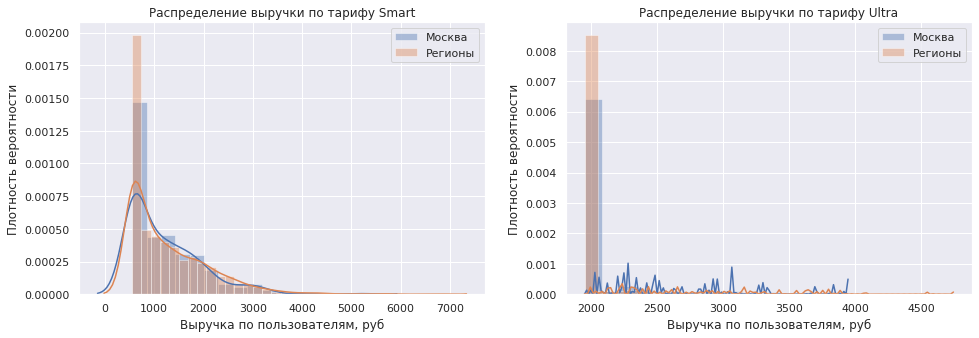

In [26]:
#Строим гистограмму распределения выручки по заданному критерию:
#Примечание: в тренажере, видимо, не установлен последний seaborn, нужный график не отображается. Выведу другой.
#sns.displot(data=data.sort_values(by = 'tariff'),
#            x='revenue_month',
#            hue='tariff',
#            col='moscow_regions',
#            bins=30,
#            kde=True)
#plt.show()

sns.set()
fig,axes=plt.subplots(1,2)
for regions in ['Москва', 'Регионы']:
  ax = sns.distplot(data.query('tariff == "smart" and moscow_regions == @regions')['revenue_month'], label = regions, ax = axes[0])
  ax1 = sns.distplot(data.query('tariff == "ultra"and moscow_regions == @regions')['revenue_month'], label = regions, ax = axes[1])

ax.set(title = "Распределение выручки по тарифу Smart",
      xlabel = "Выручка по пользователям, руб",
      ylabel = "Плотность вероятности")
ax1.set(title = "Распределение выручки по тарифу Ultra",
      xlabel = "Выручка по пользователям, руб",
      ylabel = "Плотность вероятности")
      
ax.legend()
ax1.legend()
plt.show()

In [27]:
data_smart_moscow = data.query('tariff == "smart" and moscow_regions == "Москва"')
data_smart_regions = data.query('tariff == "smart" and moscow_regions == "Регионы"')
print('Характеристики распределения ежемесячной выручки по тарифу "Smart" в Москве:')
display(data_smart_moscow[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки по тарифу "Smart" в регионах:')
display(data_smart_regions[['revenue_month']].describe().style.format('{:.2f}'))

data_ultra_moscow = data.query('tariff == "ultra" and moscow_regions == "Москва"')
data_ultra_regions = data.query('tariff == "ultra" and moscow_regions == "Регионы"')
print('Характеристики распределения ежемесячной выручки по тарифу "Ultra" в Москве:')
display(data_ultra_moscow[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки по тарифу "Ultra" в регионах:')
display(data_ultra_regions[['revenue_month']].describe().style.format('{:.2f}'))

Характеристики распределения ежемесячной выручки по тарифу "Smart" в Москве:


,revenue_month
count,386.00
mean,1198.43
std,727.73
min,550.00
25%,550.00
50%,979.55
75%,1624.09
max,5222.43


Характеристики распределения ежемесячной выручки по тарифу "Smart" в регионах:


,revenue_month
count,1843.00
mean,1261.19
std,810.56
min,550.00
25%,556.42
50%,988.16
75%,1723.54
max,6765.02


Характеристики распределения ежемесячной выручки по тарифу "Ultra" в Москве:


,revenue_month
count,225.00
mean,2063.63
std,330.57
min,1950.00
25%,1950.00
50%,1950.00
75%,1950.00
max,3945.26


Характеристики распределения ежемесячной выручки по тарифу "Ultra" в регионах:


,revenue_month
count,760.00
mean,2059.61
std,363.78
min,1950.00
25%,1950.00
50%,1950.00
75%,1950.00
max,4743.31


По графикам и характеристикам распределения выручки по Москве и регионам можно увидеть:


*   **Характер распределения выручки** по обоим тарифам в Москве и за её пределами **одинаков**;
*   **Средняя выручка в регионах чуть выше**, чем аналогичный показатель по Москве.


Проведем тест, чтобы отвергнуть/подтвердить нулевую гипотезу отдельно по каждому тарифу.


Рассчитываем критерий Левене о равенстве дисперсий выручки по тарифу Smart в Москве/регионах. 

In [28]:
m_s = data_smart_moscow['revenue_month']
r_s = data_smart_regions['revenue_month']

stat, p = levene(m_s, r_s)

print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.11623734361911198
Не получилось отвергнуть нулевую гипотезу


Принимаем нулевую гипотезу о равенстве дисперсий выручки, отразим это в параметре equal_var ниже при проведении Т-теста.

In [29]:
#Проверяем гипотезу о равенстве выручки по тарифу Smart:
alpha = 0.05
results = st.ttest_ind(
    data_smart_moscow['revenue_month'], 
    data_smart_regions['revenue_month'],
    equal_var = True)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.15952707795729637
Не получилось отвергнуть нулевую гипотезу


Вероятность ошибки при отклонении нулевой гипотезы около 16%. При такой вероятности отвергнуть её не получится. Будем считать, что **выручка по тарифу "Smart" в Москве и регионах варьирует незначительно**. 

Теперь проверим такую же гипотезу по тарифу "Ultra".
Проводим тест Левене на равенство дисперсий совокупности, чтобы сделать более точным Т-тест.

In [30]:
m_u = data_ultra_moscow['revenue_month']
r_u = data_ultra_regions['revenue_month']

stat, p = levene(m_u, r_u)

print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.88206811444585
Не получилось отвергнуть нулевую гипотезу


Принимаем гипотезу: дисперсии выборок, как и совокупностей, равны. Отразим это в параметре equal_var при расчете ниже.

In [31]:
#Проверяем гипотезу о равенстве выручки по тарифу Ultra:
alpha = 0.05
results = st.ttest_ind(
    data_ultra_moscow['revenue_month'], 
    data_ultra_regions['revenue_month'],
    equal_var = True)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8820681144458327
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

Все супер, добавь еще проверку гипотезы с разбивкой Москва/неМосква, без деления по тарифам

<div class="alert alert-success">
СДЕЛАНО! (НИЖЕ)

Вероятность ошибки при отклонении этой гипотезы - болльше 88%. То есть с высокой долей вероятности мы можем утверждать, что **по тарифу "Ultra" выручка будет одинаковой по всей стране** и будет примерно равна абонентской плате. Это подтверждает наша выборка - большинство абонентов укладывается в ежемесячные лимиты, установленные оператором.

Третьим этапом сравним выручку сотового оператора по локации абонентов без разбивки по тарифам.
Нулевая гипотеза - выручка одинакова вне зависимости от региона.

Считаем характеристики распределения выручки по Москве и регионам.

In [32]:
data_moscow = data.query('moscow_regions == "Москва"')
data_regions = data.query('moscow_regions == "Регионы"')
print('Характеристики распределения ежемесячной выручки оператора в Москве:')
display(data_moscow[['revenue_month']].describe().style.format('{:.2f}'))
print('Характеристики распределения ежемесячной выручки оператора в регионах:')
display(data_regions[['revenue_month']].describe().style.format('{:.2f}'))


Характеристики распределения ежемесячной выручки оператора в Москве:


,revenue_month
count,611.00
mean,1517.04
std,740.82
min,550.00
25%,766.00
50%,1730.27
75%,1950.00
max,5222.43


Характеристики распределения ежемесячной выручки оператора в регионах:


,revenue_month
count,2603.00
mean,1494.31
std,797.21
min,550.00
25%,704.50
50%,1544.34
75%,1950.00
max,6765.02


Как и выше, проводим тест Левене на равенство дисперсий совокупности, чтобы сделать более точным Т-тест.

In [33]:
m = data_moscow['revenue_month']
r = data_regions['revenue_month']
alpha = 0.05
stat, p = levene(m,r)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.017085270612544515
Отвергаем нулевую гипотезу


Дисперсии выборок, как и совокупностей, не равны. Отразим это в параметре equal_var при расчете ниже.

In [34]:
#Проверяем гипотезу о равенстве выручки в целом по Москве/регионам:
alpha = 0.05
results = st.ttest_ind(
    data_moscow['revenue_month'], 
    data_regions['revenue_month'],
    equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5014487809585113
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

![](https://i.gifer.com/fy22.gif)

Таким образом, вероятность ошибки при отклонении нулевой гипотезы около 50%. Или ошибёмся, или нет :). Принимаем, что выручка оператора не зависит от места проживания абонента. 

# 7. Выводы <a id="end"></a>

Проведя статистический анализ выборки из 500 абонентов сотового оператора, можем сделать следующие выводы:


*   Основные различия между пользовательским поведением - **значительное увеличение потребления интернет-трафика на тарифе "Ultra"**. Длительность звонков и отправка сообщений значительно не различаются. 
*   **Пользователи тарифа "Smart" в половине случаев не укладываются в лимиты звонков и трафика**, но даже с учетом оплаты сверх лимита тратят в среднем меньше суммы абонентской платы тарифа "Ultra".
*   **Тариф "Ultra" более выгоден для мобильного оператора**. Меньше 25% пользователей превышают лимиты, но средняя выручка выше за счет высокой абонентской платы. 
*   Возможно, маркетологам стоит поработать с характеристиками тарифа "Ultra", чтобы сделать его более привлекательным для потенциальных абонентов. 
*   В Москве доля клиентов с тарифом "Ultra" - 37%, в регионах - 29%. При этом **абоненты тарифа "Smart" из регионов в среднем приносят чуть больше выручки**, т.е. более интенсивно используют мобильную связь. На это тоже следует обратить внимание маркетологам при выборе таргет-группы для рекламы.
*   За счёт того, что в Москве доля тарифа "Ultra" выше, чем в регионах, средняя выручка по этому городу чуть выше. Однако незначительно, что и показал тест на равенство суммарной выручки. Это еще один плюс в пользу предположения, что **в регионах больше потенциал для привлечения новых "Ultra"-клиентов**.

 

<div style="border:solid purple 2px; padding: 20px">

Работа выполнена на очень высоком уровне, ты хорошо используешь собственные функции, отлично визуализируешь распределения, на каждом шаге аргументируешь свой выбор. Мне понравился твой очень вдумчивый подход к работе.

Остались небольшие доработки:

- В шаге 4 необходимо дополнить проверку 2 гипотезы

Я уверен, ты легко справишься с доработками, жду твоих исправлений 😊

<div>

<div class="alert alert-success">
    СПАСИБО! ВСЁ УЧЛА. 

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 <a class="tocSkip"> </h2>

Спасибо тебе Марина, за качественный проект. Такие работы проверять одно удовольствие! Работу я, конечно же, принимаю, и желаю удачи в последующих проектах. Надеюсь, мы еще встретимся)

</div>